In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Reshape, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from PIL import Image
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X_train = pd.read_csv("./data/ClustREFGenes-master/Data/Core_genome/Data_Core_Genome_Ecoli_log2.csv",
                  index_col=0)
print("Dimensionalidade dos dados: ", X_train.shape)
X_train.head()

Dimensionalidade dos dados:  (4051, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
Genes,,,,,,,,,
accD,6.875411,7.047582,7.431765,7.105877,6.516094,6.676126,6.304694,6.168221,6.245553
aceF,7.732412,7.674997,8.397717,7.455056,7.277269,6.525536,7.455730,6.403830,7.597941
ackA,7.231720,7.260976,8.033280,6.921924,6.920829,6.556644,6.358150,5.888768,6.359310
agaV,6.048825,6.250033,5.120269,5.559767,5.915593,6.279490,6.441998,6.553099,6.105364
alaS,7.811728,7.853890,8.622037,7.636451,7.641365,7.125920,7.164957,6.555678,7.098590


### PCA:
- para ver a distribuição dos dados, estes serão reduzidos à só dois dimensões com PCA.

In [3]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [4]:
X_pca = pca.transform(X_train)
print("Dimensionalidade: ", X_pca.shape)

Dimensionalidade:  (4051, 2)


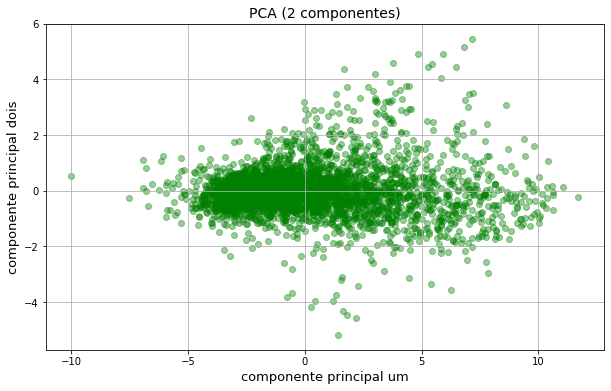

In [5]:
plt.figure(figsize=(10,6))
plt.title("PCA (2 componentes)", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_pca[:,0], X_pca[:,1], color="green", alpha=.4);

### Normalização dos dados
- Para poder fazer uso das GAN's, a gente tem que normalizar os dados, para eso é usada a seguinte normalização:
<br><br>
$$X = \left(\frac{x_{i} - min(X)}{max(X)}\right).\left(MAX - MIN\right) + MIN$$

In [6]:
max_val = 1
min_val = -1
X_train = ((X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train)))*(max_val - min_val) + min_val

- vou trocar a dimensionalidade de cada gen, por uma dimesionalidade de 3x3, para assim ver o gen como uma matrix.

In [7]:
X_img = np.array(X_train).reshape((X_train.shape[0],3,3,1))
X_lab = X_train.index

----------------------------- Genomas representados na forma de uma matriz -----------------------------


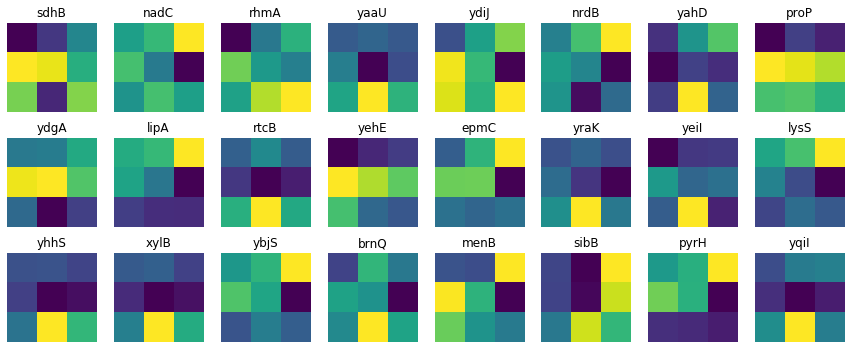

In [8]:
idx = np.random.randint(low=0, high=X_train.shape[0], size=24)
imgs =  X_img[idx]
titles = X_lab[idx]
fig = plt.figure(figsize=(15,6))
p=0
#plt.title("Genomas representados na forma de uma imagem", fontsize=12)
plt.axis("off");
print("----------------------------- Genomas representados na forma de uma matriz -----------------------------")
for i in imgs:
    ax=fig.add_subplot(3,8,p+1)
    plt.title(titles[p])
    plt.imshow(i.reshape(3,3))
    plt.axis("off");
    p += 1

### Dados fake
- Os dados que vão ser passados pro gerador, são dados de uma distribuição normal.
- O gráfico abaixo mostra os dados reais e os dados da distribuição normal os quais são para trenar a rede geradora.

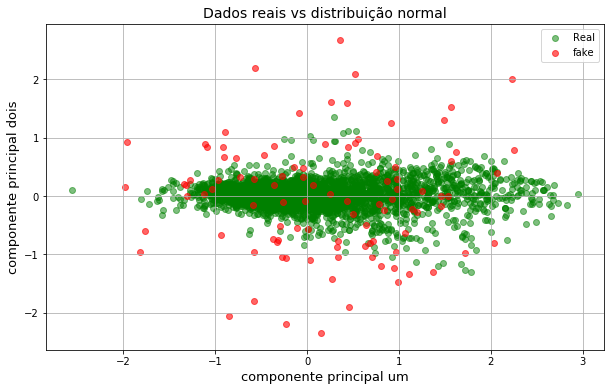

In [9]:
pca2 = PCA(n_components=2)
pca2.fit(X_train)
X_real = pca2.transform(X_train)
X_fake = pca2.transform(np.random.normal(0,1,(100,9)))
plt.figure(figsize=(10,6))
plt.grid()
plt.title("Dados reais vs distribuição normal", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_real[:,0], X_real[:,1], label="Real", alpha=.5, color="green")
plt.scatter(X_fake[:,0], X_fake[:,1], label="fake", alpha=.6, color="red")
plt.legend();

### Construção da GAN
- A GAN conta com dois redes, uma rede geradora e uma discriminadora.

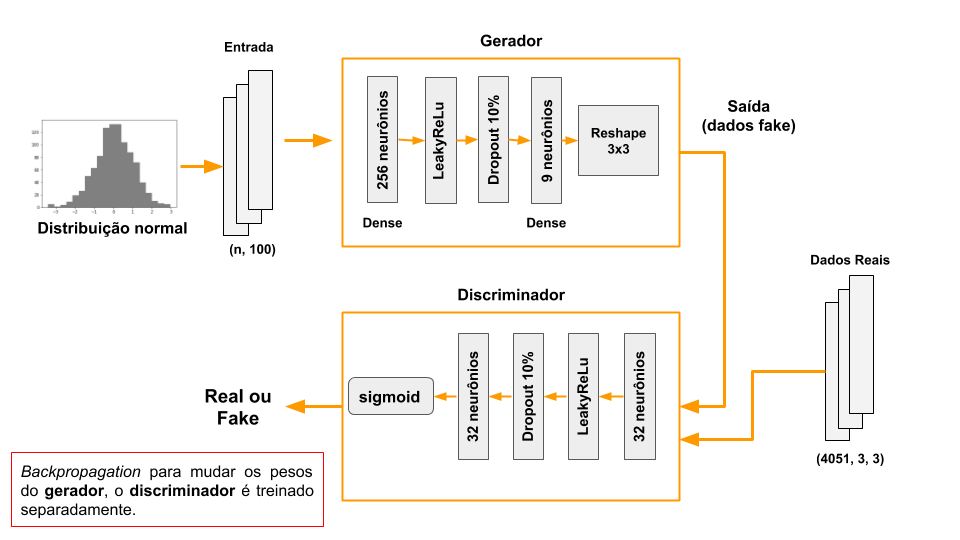

In [10]:
Image.open("./images/image1.png")

In [11]:
class GANs():
    #inialização dos parâmetros
    def __init__(self, width, height, channels, noise_input):
        self.width = width
        self.height = height
        self.channels = channels
        self.dim = (self.width, self.height, self.channels)
        self.noise_input = noise_input
        self.g_loss = []
        self.d_loss = []
        self.g_lpe = []
        self.d_lpe = []
        self.optimizerD = Adam(lr=0.0001, beta_1=0.5)
        self.optimizerG = Adam(lr=0.0004, beta_1=0.5)
        self.G = self.noise_generator()
        print("Compilando o gerador...")
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizerG)
        self.D = self.discriminator()
        print("Compilando o discriminador...")
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizerD, metrics=['accuracy'])
        self.stacked_generator_discriminator = Sequential()
        self.stacked_generator_discriminator.add(self.G)
        self.D.trainable = False #para que a rede D nao seja treinada no stacked
        self.stacked_generator_discriminator.add(self.D)
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizerG)
        
    #criação do gerador de imagens fake
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(self.noise_input,)))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dropout(.1))
        model.add(Dense(self.width*self.height*self.channels, activation="tanh"))
        model.add(Reshape((self.width, self.height, self.channels)))
        return model
    
    #criação do discriminador
    def discriminator(self):
        model = Sequential()
        model.add(Dense(32, input_shape=self.dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dropout(.1))
        model.add(Dense(32))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        return model

    #Para obter o sumary do gerador
    def summary_gerador(self):
        return self.G.summary()
    
    #Para obter o sumary do gerador
    def summary_discriminador(self):
        return self.D.summary()
        
    #pra obter os batches pra o treino
    def get_batches(self, X_train, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > X_train.shape[0]:
                lim_s = X_train.shape[0]
            batches.append(X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
            
        return batches
        
    #devolve o loss do gerador e do discriminador
    def get_loss(self):
        return [self.g_loss, self.d_loss]
    
    #treinamento da GAN
    def train(self, X_train, epochs, batch_size):
        self.d_loss = []
        self.g_loss = []
        self.g_lpe = []
        self.d_lpe = []
        for cnt in range(epochs):
            batches = self.get_batches(X_train, batch_size)
            count_b = 0
            t_i = time()
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake
                syntetic_images = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_images))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #misturar os dados
                #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
                #treino do discriminador
                d_l = self.D.train_on_batch(x_combined_batch, y_combined_batch)
                self.d_loss.append(d_l[0])
                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))

                g_l = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
                self.g_loss.append(g_l)
                count_b += 1
                if (count_b%len(batches))==0:
                    t_f = time()
                    t = t_f - t_i
                    t_i = time()
                    print ('epoch:[%d/%d] batch:[%d/%d], [Discriminator::d_loss: %f], [Generator::loss: %f], %f[sec]'
                               % (cnt+1,epochs,count_b,len(batches),d_l[0],g_l,t))
            self.g_lpe.append(g_l)
            self.d_lpe.append(d_l[0])

In [12]:
noise_input = 100
gan = GANs(width=3, height=3, channels=1, noise_input=noise_input)

Compilando o gerador...
Compilando o discriminador...


imagens fake:  (300, 3, 3, 1)
re-dimesionalidade:  (300, 9)


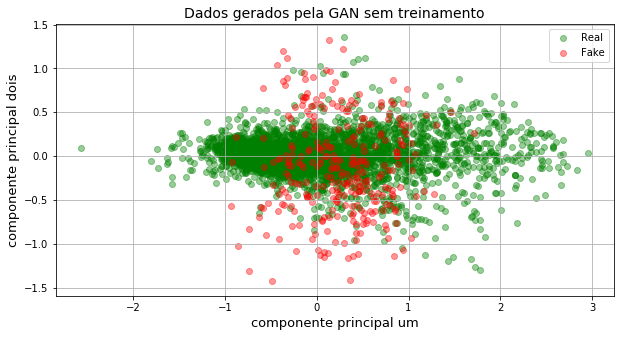

In [13]:
num_imgs = 300
fakes = gan.G.predict(np.random.normal(0,1,(num_imgs,noise_input)))
print("imagens fake: ", fakes.shape)
fakes = fakes.reshape(num_imgs,9)
print("re-dimesionalidade: ", fakes.shape)
pca2 = PCA(n_components=2)
pca2.fit(X_img.reshape(X_img.shape[0],9))

X_real = pca2.transform(X_img.reshape(X_img.shape[0],9))
X_fake = pca2.transform(fakes)
plt.figure(figsize=(10,5))
plt.title("Dados gerados pela GAN sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_real[:,0], X_real[:,1], color="green", alpha=.4, label="Real")
plt.scatter(X_fake[:,0], X_fake[:,1], color="red", alpha=.4, label="Fake")
plt.legend();

In [14]:
print("-----------------------Estrutura da rede generativa-----------------------")
gan.G.summary()

-----------------------Estrutura da rede generativa-----------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 2313      
_________________________________________________________________
reshape (Reshape)            (None, 3, 3, 1)           0         
Total params: 28,169
Trainable params: 28,169
Non-trainable params: 0
_________________________________________________________________


In [15]:
print("-----------------------Estrutura da rede Discriminadora-----------------------")
gan.D.summary()

-----------------------Estrutura da rede Discriminadora-----------------------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3, 3, 32)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 32)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 3, 3, 32)          1056      
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 289       
Total params: 2,818
Trainable params: 1,4

In [ ]:
t_i = time()
gan.train(X_img, epochs=400,batch_size=32)
t_f = time()

epoch:[1/400] batch:[127/127], [Discriminator::d_loss: 0.692035], [Generator::loss: 0.723120], 6.887915[sec]
epoch:[2/400] batch:[127/127], [Discriminator::d_loss: 0.670530], [Generator::loss: 0.725637], 6.682471[sec]
epoch:[3/400] batch:[127/127], [Discriminator::d_loss: 0.677085], [Generator::loss: 0.716515], 6.625888[sec]
epoch:[4/400] batch:[127/127], [Discriminator::d_loss: 0.691313], [Generator::loss: 0.704194], 6.679765[sec]
epoch:[5/400] batch:[127/127], [Discriminator::d_loss: 0.690982], [Generator::loss: 0.703443], 6.723778[sec]
epoch:[6/400] batch:[127/127], [Discriminator::d_loss: 0.695760], [Generator::loss: 0.700074], 6.700576[sec]
epoch:[7/400] batch:[127/127], [Discriminator::d_loss: 0.692430], [Generator::loss: 0.700158], 6.766863[sec]
epoch:[8/400] batch:[127/127], [Discriminator::d_loss: 0.690979], [Generator::loss: 0.703360], 6.524651[sec]
epoch:[9/400] batch:[127/127], [Discriminator::d_loss: 0.691743], [Generator::loss: 0.704259], 6.836426[sec]
epoch:[10/400] batc

epoch:[76/400] batch:[127/127], [Discriminator::d_loss: 0.690580], [Generator::loss: 0.697005], 8.950573[sec]
epoch:[77/400] batch:[127/127], [Discriminator::d_loss: 0.692530], [Generator::loss: 0.694625], 6.939714[sec]
epoch:[78/400] batch:[127/127], [Discriminator::d_loss: 0.693945], [Generator::loss: 0.695123], 6.604900[sec]
epoch:[79/400] batch:[127/127], [Discriminator::d_loss: 0.697869], [Generator::loss: 0.693709], 6.593772[sec]
epoch:[80/400] batch:[127/127], [Discriminator::d_loss: 0.693475], [Generator::loss: 0.691010], 6.571516[sec]
epoch:[81/400] batch:[127/127], [Discriminator::d_loss: 0.694396], [Generator::loss: 0.693640], 6.588011[sec]
epoch:[82/400] batch:[127/127], [Discriminator::d_loss: 0.689829], [Generator::loss: 0.698778], 6.703831[sec]
epoch:[83/400] batch:[127/127], [Discriminator::d_loss: 0.697589], [Generator::loss: 0.693096], 6.618727[sec]
epoch:[84/400] batch:[127/127], [Discriminator::d_loss: 0.693707], [Generator::loss: 0.691281], 7.247018[sec]
epoch:[85/

epoch:[150/400] batch:[127/127], [Discriminator::d_loss: 0.694143], [Generator::loss: 0.691513], 6.969626[sec]
epoch:[151/400] batch:[127/127], [Discriminator::d_loss: 0.693310], [Generator::loss: 0.693125], 7.411857[sec]
epoch:[152/400] batch:[127/127], [Discriminator::d_loss: 0.694636], [Generator::loss: 0.686456], 7.281807[sec]
epoch:[153/400] batch:[127/127], [Discriminator::d_loss: 0.691010], [Generator::loss: 0.695481], 7.400978[sec]
epoch:[154/400] batch:[127/127], [Discriminator::d_loss: 0.693973], [Generator::loss: 0.697783], 7.382207[sec]
epoch:[155/400] batch:[127/127], [Discriminator::d_loss: 0.696448], [Generator::loss: 0.692692], 7.918805[sec]
epoch:[156/400] batch:[127/127], [Discriminator::d_loss: 0.693464], [Generator::loss: 0.689033], 7.385214[sec]
epoch:[157/400] batch:[127/127], [Discriminator::d_loss: 0.695456], [Generator::loss: 0.693572], 7.656671[sec]
epoch:[158/400] batch:[127/127], [Discriminator::d_loss: 0.692184], [Generator::loss: 0.697357], 6.907990[sec]
e

epoch:[224/400] batch:[127/127], [Discriminator::d_loss: 0.695711], [Generator::loss: 0.695208], 7.422116[sec]
epoch:[225/400] batch:[127/127], [Discriminator::d_loss: 0.695140], [Generator::loss: 0.693793], 7.171359[sec]
epoch:[226/400] batch:[127/127], [Discriminator::d_loss: 0.696389], [Generator::loss: 0.693976], 7.477578[sec]
epoch:[227/400] batch:[127/127], [Discriminator::d_loss: 0.692600], [Generator::loss: 0.688534], 7.228696[sec]
epoch:[228/400] batch:[127/127], [Discriminator::d_loss: 0.695811], [Generator::loss: 0.698249], 7.227731[sec]
epoch:[229/400] batch:[127/127], [Discriminator::d_loss: 0.693600], [Generator::loss: 0.693056], 7.326643[sec]
epoch:[230/400] batch:[127/127], [Discriminator::d_loss: 0.692945], [Generator::loss: 0.693823], 18.502939[sec]
epoch:[231/400] batch:[127/127], [Discriminator::d_loss: 0.691614], [Generator::loss: 0.693573], 7.256787[sec]
epoch:[232/400] batch:[127/127], [Discriminator::d_loss: 0.694439], [Generator::loss: 0.696993], 7.091434[sec]


In [19]:
print("tempo de execução: ", (t_f-t_i)/60, "[min]")

tempo de execução:  2.651117221514384 [min]


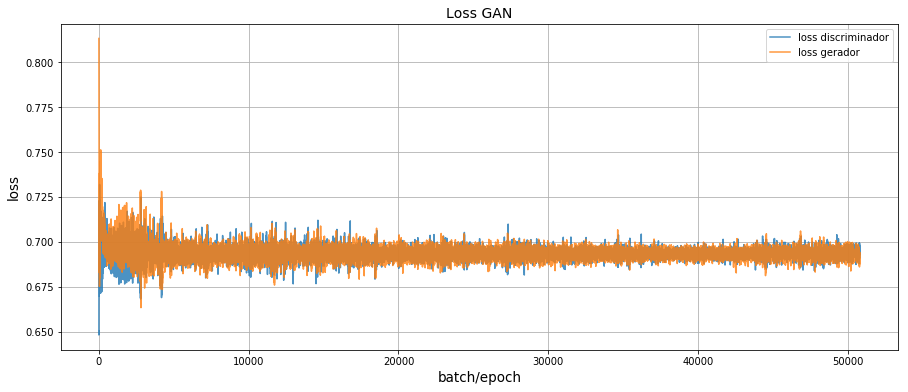

In [20]:
g_loss, d_loss = gan.get_loss()

plt.figure(figsize=(15,6))
#plt.plot(range(len(g_loss)), g_loss)
plt.title("Loss GAN", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("batch/epoch", fontsize=13.5)
plt.plot(range(np.array(d_loss).shape[0]), np.array(d_loss), label="loss discriminador", alpha=.8)
plt.plot(range(np.array(g_loss).shape[0]), np.array(g_loss), label="loss gerador", alpha=.8)
#plt.plot(range(np.array(g_loss).shape[0]), 0.5*np.ones(np.array(g_loss).shape[0]),
#         color="black", label="objetivo", linestyle='--')
plt.grid()
#plt.yticks([0, 0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.legend();

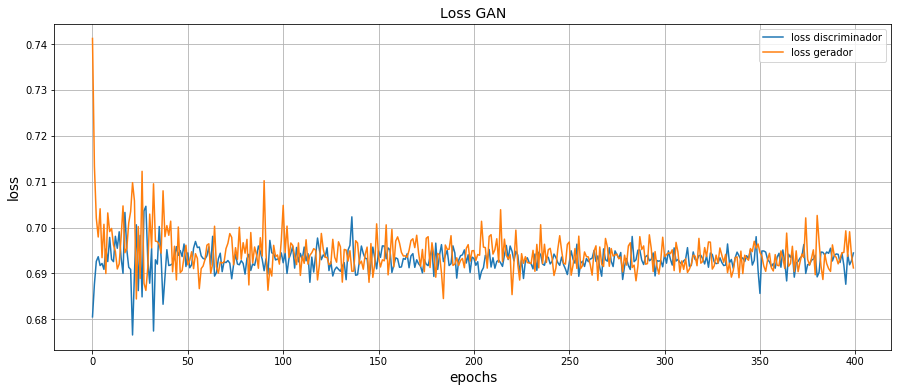

In [21]:
plt.figure(figsize=(15,6))
plt.title("Loss GAN", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("epochs", fontsize=13.5)
plt.plot(range(len(gan.d_lpe)), np.array(gan.d_lpe), label="loss discriminador")
plt.plot(range(len(gan.g_lpe)), np.array(gan.g_lpe), label="loss gerador")
#plt.plot(range(len(gan.g_lpe)), 0.5*np.ones(len(gan.g_lpe)),
#         color="black", label="objetivo", linestyle='--')
plt.grid()
plt.legend();

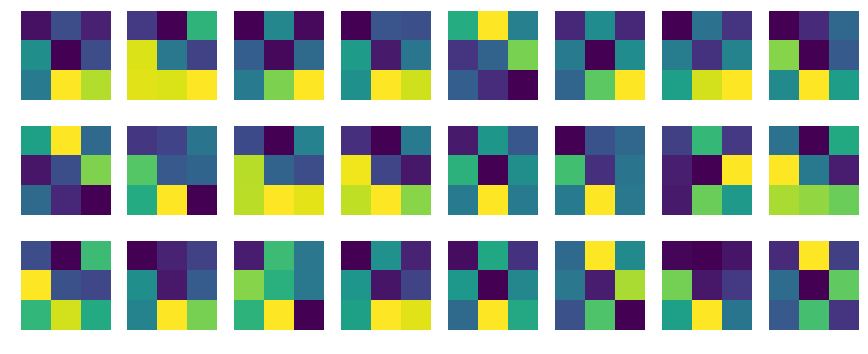

In [22]:
num_imgs = 24 #número de imágenes a mostrar aleatoriamente
img_pre = gan.G.predict(np.random.normal(0,1,(num_imgs, noise_input)))
fig = plt.figure(figsize=(15,6))
for i in range(num_imgs):
    ax=fig.add_subplot(3,8,i+1)
    img = img_pre[i]
    plt.imshow(img.reshape((3,3)))
    ax.axis("off")
plt.show()

In [23]:
num_imgs = 300
fakes = gan.G.predict(np.random.normal(0,1,(num_imgs,noise_input)))
print("imagens fake: ", fakes.shape)
fakes = fakes.reshape(num_imgs,9)
print("re-dimesionalidade: ", fakes.shape)
pca2 = PCA(n_components=2)
pca2.fit(X_img.reshape(X_img.shape[0],9))

X_real = pca2.transform(X_img.reshape(X_img.shape[0],9))
X_fake = pca2.transform(fakes)

imagens fake:  (300, 3, 3, 1)
re-dimesionalidade:  (300, 9)


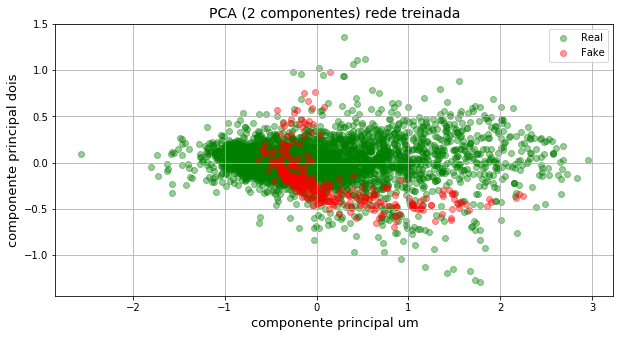

In [24]:
plt.figure(figsize=(10,5))
plt.title("PCA (2 componentes) rede treinada", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_real[:,0], X_real[:,1], color="green", alpha=.4, label="Real")
plt.scatter(X_fake[:,0], X_fake[:,1], color="red", alpha=.4, label="Fake")
plt.legend();

In [26]:
num_imgs = 300
fakes = gan.G.predict(np.random.normal(0,1,(num_imgs,noise_input)))
print("Dados fake: ", fakes.shape)
y_predict = gan.D.predict_classes(fakes)
print("-------------- Discriminador --------------")
print("porcentagem de dados fake que o discriminador acredita reais: ", np.mean(y_predict==1))
print("porcentagem de dados fake que o discriminador acredita fakes: ", np.mean(y_predict==0))
print()
y_predict2 = gan.D.predict_classes(X_img)
print("-------------- Discriminador com dados reais --------------")
print("porcentagem de dados reais que o discriminador acredita reais: ", np.mean(y_predict2==1))
print("porcentagem de dados reais que o discriminador acredita fakes: ", np.mean(y_predict2==0))

Dados fake:  (300, 3, 3, 1)
-------------- Discriminador --------------
porcentagem de dados fake que o discriminador acredita reais:  0.7266666666666667
porcentagem de dados fake que o discriminador acredita fakes:  0.2733333333333333

-------------- Discriminador com dados reais --------------
porcentagem de dados reais que o discriminador acredita reais:  0.22636386077511725
porcentagem de dados reais que o discriminador acredita fakes:  0.7736361392248827


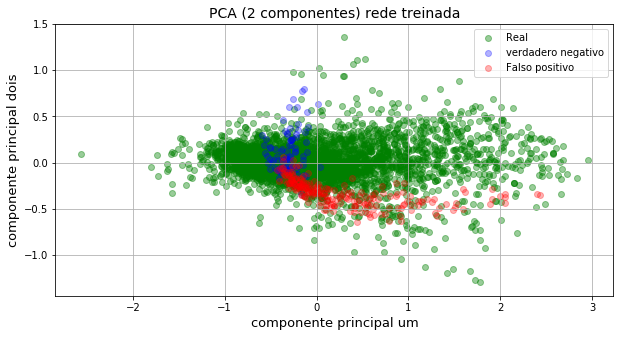

In [27]:
fakes = fakes.reshape(num_imgs,9)

pca2 = PCA(n_components=2)
pca2.fit(X_img.reshape(X_img.shape[0],9))

X_real = pca2.transform(X_img.reshape(X_img.shape[0],9))
X_fake = pca2.transform(fakes)
X_fp = X_fake[np.where(y_predict==1)[0]]
X_vn = X_fake[np.where(y_predict==0)[0]]

plt.figure(figsize=(10,5))
plt.title("PCA (2 componentes) rede treinada", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_real[:,0], X_real[:,1], color="green", alpha=.4, label="Real")
plt.scatter(X_vn[:,0], X_vn[:,1], color="blue", alpha=.3, label="verdadero negativo")
plt.scatter(X_fp[:,0], X_fp[:,1], color="red", alpha=.3, label="Falso positivo")
plt.legend();

In [28]:
bp_fp = []
bp_vn = []
for i in range(300):
    fakes = gan.G.predict(np.random.normal(0,1,(num_imgs,noise_input)))
    y_predict = gan.D.predict_classes(fakes)
    bp_fp.append(np.mean(y_predict==1))
    bp_vn.append(np.mean(y_predict==0))

In [29]:
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.layouts import row
from bokeh.models import ColumnDataSource

output_notebook()
x_ticks = ["falsos_positivos"]
p1 = figure(tools="", background_fill_color="#efefef", toolbar_location=None, x_range=x_ticks,
           title="Falsos positivos do discriminador", width=450, height=500)
q1 = np.quantile(bp_fp, q=0.25)
q2 = np.quantile(bp_fp, q=0.5)
q3 = np.quantile(bp_fp, q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
outliers = np.array(bp_fp)[(bp_fp>upper) + (bp_fp<lower)]
source1 = ColumnDataSource(dict(x=x_ticks, upper=[upper], lower=[lower], q1=[q1], q2=[q2], q3=[q3]))
source2 = ColumnDataSource(dict(x=x_ticks*len(outliers), y=outliers))
#Para graficar las lineas superiores del boxplot
p1.rect("x","upper",0.2,0.0003, line_color="black", fill_color="black", source=source1)
#Para graficar las lineas inferiores del boxplot
p1.rect("x", "lower", 0.2, 0.0003, line_color="black", fill_color="black", source=source1)
#Para graficar los segmentos del boxplot
p1.segment("x", "lower", "x", "q1", line_color="black", source=source1)
p1.segment("x", "upper", "x", "q3", line_color="black", source=source1)
#Para graficar las barras
p1.vbar("x", 0.3, "q1", "q2", fill_color="#3B8686", line_color="black", source=source1, legend="q1 até q2")
p1.vbar("x", 0.3, "q2", "q3", fill_color="#E08E79", line_color="black", source=source1, legend="q2 até q3")
p1.circle("x","y", size=8, color="#F38630", fill_alpha=0.6, source=source2)

x_ticks2 = ["verdaderos negativos"]
p2 = figure(tools="", background_fill_color="#efefef", toolbar_location=None, x_range=x_ticks2,
           title="Verdaderos negativos do discriminador", width=450, height=500)
p2_q1 = np.quantile(bp_vn, q=0.25)
p2_q2 = np.quantile(bp_vn, q=0.5)
p2_q3 = np.quantile(bp_vn, q=0.75)
p2_iqr = p2_q3 - p2_q1
p2_upper = p2_q3 + 1.5*iqr
p2_lower = p2_q1 - 1.5*iqr
outliers2 = np.array(bp_vn)[(bp_vn>p2_upper) + (bp_vn<p2_lower)]
source3 = ColumnDataSource(dict(x=x_ticks2, upper=[p2_upper], lower=[p2_lower],
                                q1=[p2_q1], q2=[p2_q2], q3=[p2_q3]))
source4 = ColumnDataSource(dict(x=x_ticks2*len(outliers2), y=outliers2))
#Para graficar las lineas superiores del boxplot
p2.rect("x","upper",0.2,0.0003, line_color="black", fill_color="black", source=source3)
#Para graficar las lineas inferiores del boxplot
p2.rect("x", "lower", 0.2, 0.0003, line_color="black", fill_color="black", source=source3)
#Para graficar los segmentos del boxplot
p2.segment("x", "lower", "x", "q1", line_color="black", source=source3)
p2.segment("x", "upper", "x", "q3", line_color="black", source=source3)
#Para graficar las barras
p2.vbar("x", 0.3, "q1", "q2", fill_color="#3B8686", line_color="black", source=source3, legend="q1 até q2")
p2.vbar("x", 0.3, "q2", "q3", fill_color="#E08E79", line_color="black", source=source3, legend="q2 até q3")
p2.circle("x","y", size=8, color="#F38630", fill_alpha=0.6, source=source4)

show(row([p1,p2]))

Loading BokehJS ...

In [187]:
#gan.D.save_weights("D_weights.h5")
#gan.G.save_weights("G_weights.h5")
#gan.stacked_generator_discriminator.save_weights("stacked_weights.h5")